<a href="https://colab.research.google.com/github/xKDR/Legal-Notebooks/blob/main/extracting_judge_names.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sponsored by E2E networks.

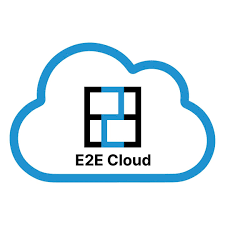

## 2.1 Installing packages

To set up our cloud-based environment, we install the necessary Python packages using the pip command in Google Colab. Below is the code snippet used for installation:

In [ ]:
import sys
sys.executable


'/usr/bin/python3'

In [ ]:
%%capture

# Package for running LLMs locally
!pip install langchain==0.3
!pip install langchain-core==0.3
!pip install langchain-community==0.3
!pip install langchain openai
!pip install langchain-groq



# Package for working with SQL lite database
!pip install sqlite3==2.6
!pip install SQLAlchemy


# Package for reading PDF files
!pip install pdfplumber==0.11
!pip install pytesseract==0.3
!pip install pdf2image==1.17
!pip install PyMuPDF


# Machine learning packages
!pip install scikit-learn==1.5
!pip install nltk==3.8
!pip install lightgbm==4.5

# Other helpful libraries
!pip install tqdm==4.66
!pip install pandas==2.1
!pip install pillow==10.4
!pip install matplotlib==3.7

In [ ]:
%%capture

!sudo apt-get install -y poppler-utils
!sudo apt-get install tesseract-ocr
!sudo apt install pciutils

## 2.2 Import packages

After installing the necessary packages, we import the required libraries into our Python environment.

In [ ]:
import sqlite3 as db  # SQLite is a lightweight database library for managing database connections.
import io  # IO module to handle input and output operations.
import pdfplumber  # PDF processing library for extracting text from PDF files.
import pandas as pd  # Pandas is a powerful data manipulation and analysis library.

import pytesseract  # Python wrapper for Google's Tesseract-OCR Engine to perform optical character recognition (OCR).
from pdf2image import convert_from_bytes  # Converts PDF files into images for OCR processing.

import re  # Regular expressions library for string matching and manipulation.

from tqdm import tqdm  # Library for displaying progress bars during iterations.

from langchain_community.llms import Ollama # Library for connecting to Ollama

import matplotlib.pyplot as plt # 3.7.1

import os
import csv
import pdfplumber
import urllib.request
import fitz  # PyMuPDF
import requests
import pandas as pd
import subprocess


from sqlalchemy import create_engine
import regex as re
import base64
from pdfminer.pdfparser import PDFSyntaxError




# 4 Orders database

In [ ]:
# @title 4.1 Downloading the database
!wget -O orders.sqlite https://github.com/xKDR/order_substantive_classification/raw/refs/heads/main/orders.sqlite?download=

--2025-02-17 05:51:04--  https://github.com/xKDR/order_substantive_classification/raw/refs/heads/main/orders.sqlite?download=
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/xKDR/order_substantive_classification/refs/heads/main/orders.sqlite?download=true [following]
--2025-02-17 05:51:05--  https://media.githubusercontent.com/media/xKDR/order_substantive_classification/refs/heads/main/orders.sqlite?download=true
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 469602304 (448M) [application/octet-stream]
Saving to: ‘orders.sqlite’

orders.sqlite       100%[===================>] 44

`wget` is used to download the SQLite database from a GitHub repository.  It contains court order PDFs. This database will provides orders as well as their labels.

In [ ]:
# @title 4.2 Helper functions to work with the database

# Function to read PDF text from BLOB
def read_pdf_text_from_blob(pdf_blob):
    """
    Reads a PDF from binary data and returns its text content.

    :param pdf_blob: Binary data of the PDF.
    :return: Text content of the PDF.
    """
    text = ''

    if pdf_blob is not None:
        try:
            # Create a file-like object from the binary data
            pdf_file_like = io.BytesIO(pdf_blob)

            # Use pdfplumber to read the PDF from the file-like object
            with pdfplumber.open(pdf_file_like) as pdf:
                for page in pdf.pages:
                    text += page.extract_text() + "\n"  # Adding a newline for each page break
        except PDFSyntaxError:
            print("Failed to parse PDF: Is this really a PDF?")
        except Exception as e:
            print(f"An error occurred while reading the PDF: {e}")
    else:
        print("PDF binary data is None.")

    return text

def read_page_pdf_text_from_blob(pdf_blob, page):
    """
    Reads a PDF from binary data and returns its text content.

    :param pdf_blob: Binary data of the PDF.
    :return: Text content of the PDF.
    """
    text = ''

    if pdf_blob is not None:
        try:
            # Create a file-like object from the binary data
            pdf_file_like = io.BytesIO(pdf_blob)

            # Use pdfplumber to read the PDF from the file-like object
            with pdfplumber.open(pdf_file_like) as pdf:
                text = pdf.pages[page].extract_text() + "\n"
        except PDFSyntaxError:
            print("Failed to parse PDF: Is this really a PDF?")
        except Exception as e:
            print(f"An error occurred while reading the PDF: {e}")
    else:
        print("PDF binary data is None.")

    return text



def execute_query_and_return_dataframe(database_path,query):
    """
    Takes in a user  SQL query, executes it against the SQLite database at the specified path,
    and returns the results as a Pandas DataFrame.

    Parameters:
    - database_path: A string representing the full path to the SQLite database file.
    - query: User SQL query
    Returns:
    - A Pandas DataFrame containing the results of the executed query.
    """
    # Establish a connection to the SQLite database
    conn = db.connect(database_path)

    try:
        # Prompt the user for a SQL query
        query = query

        # Read SQL query into a DataFrame
        df = pd.read_sql_query(query, conn)

        # Return the DataFrame
        return df
    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame()  # Return an empty DataFrame in case of error
    finally:
        # Ensure the connection is closed even if an error occurs
        conn.close()

We define a couple of helper functions to facilitate interaction with the SQLite database. These functions include capabilities for reading PDF text from binary data, and executing SQL queries

In [ ]:
# @title 4.3 Load the database into a dataframe
db_path = "/content/orders.sqlite"

# df = execute_query_and_return_dataframe(db_path, "SELECT pdf_blob, pdf_name, court from whether_substantive")

NCLT_orders = execute_query_and_return_dataframe(db_path, "SELECT * from whether_substantive WHERE court = 'NCLT'")

NCLT_orders

,pdf_blob,pdf_name,WHETHERSUBSTANTIVE,court
0,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,cp-ib-568-2018_14062022.pdf,non_substantive,NCLT
1,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,cp-ib-1848-2019_01122021.pdf,non_substantive,NCLT
2,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,cp-ib-338-2020_14122021.pdf,non_substantive,NCLT
3,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,cp-ib-918-2020_26112021.pdf,non_substantive,NCLT
4,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,cp-ib-3447-2018_27082021.pdf,non_substantive,NCLT
...,...,...,...,...
1124,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,cp-220-2021_03032022.pdf,non_substantive,NCLT
1125,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,cp-ib-303-2021_25082021.pdf,non_substantive,NCLT
1126,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,cp-ib-3447-2018_06102022.pdf,non_substantive,NCLT
1127,b'%PDF-1.7\n%\xc7\xec\x8f\xa2\n%%Invocation: g...,cp-ib-29-2020_30032022.pdf,non_substantive,NCLT


<b> Table 4: </b> Preview of the orders database.


We load the court orders data, which is stored in an SQLite database, into a **Pandas DataFrame** for further analysis. The SQLite database contains the text of court orders, stored in a binary format (BLOB), along with metadata such as whether the hearing is substantive or non-substantive.

The steps involved in this section are as follows:

1. **Database Path**:
   The SQLite database file (`orders.sqlite`) is specified as the `db_path`. This file contains the raw data, including the binary representation of the court orders.

2. **Query the Data**:
   A function, `execute_query_and_return_dataframe`, is used to execute an SQL query on the SQLite database. The query retrieves the court order data, including the binary data (PDF BLOBs) and a column indicating whether the hearing is classified as substantive or non-substantive.

3. **Storing in a DataFrame**:
   The results of the SQL query are returned as a **Pandas DataFrame**. This DataFrame allows for easy manipulation, analysis, and preprocessing of the data. Each row in the DataFrame represents an individual court order, and the columns store the order's binary content and classification label.

4. **Columns**:
   - `pdf_blob`: The binary content of the PDF file representing the court order.
   - `pdf_name`: The name of the PDF file.
   - `court`: The name of the court issuing the order.

## 4.7 Examining original PDFs

The original PDF can be examined by converting bytes to images or text.

As an example, in the following cell, we show the first page of the first PDF.

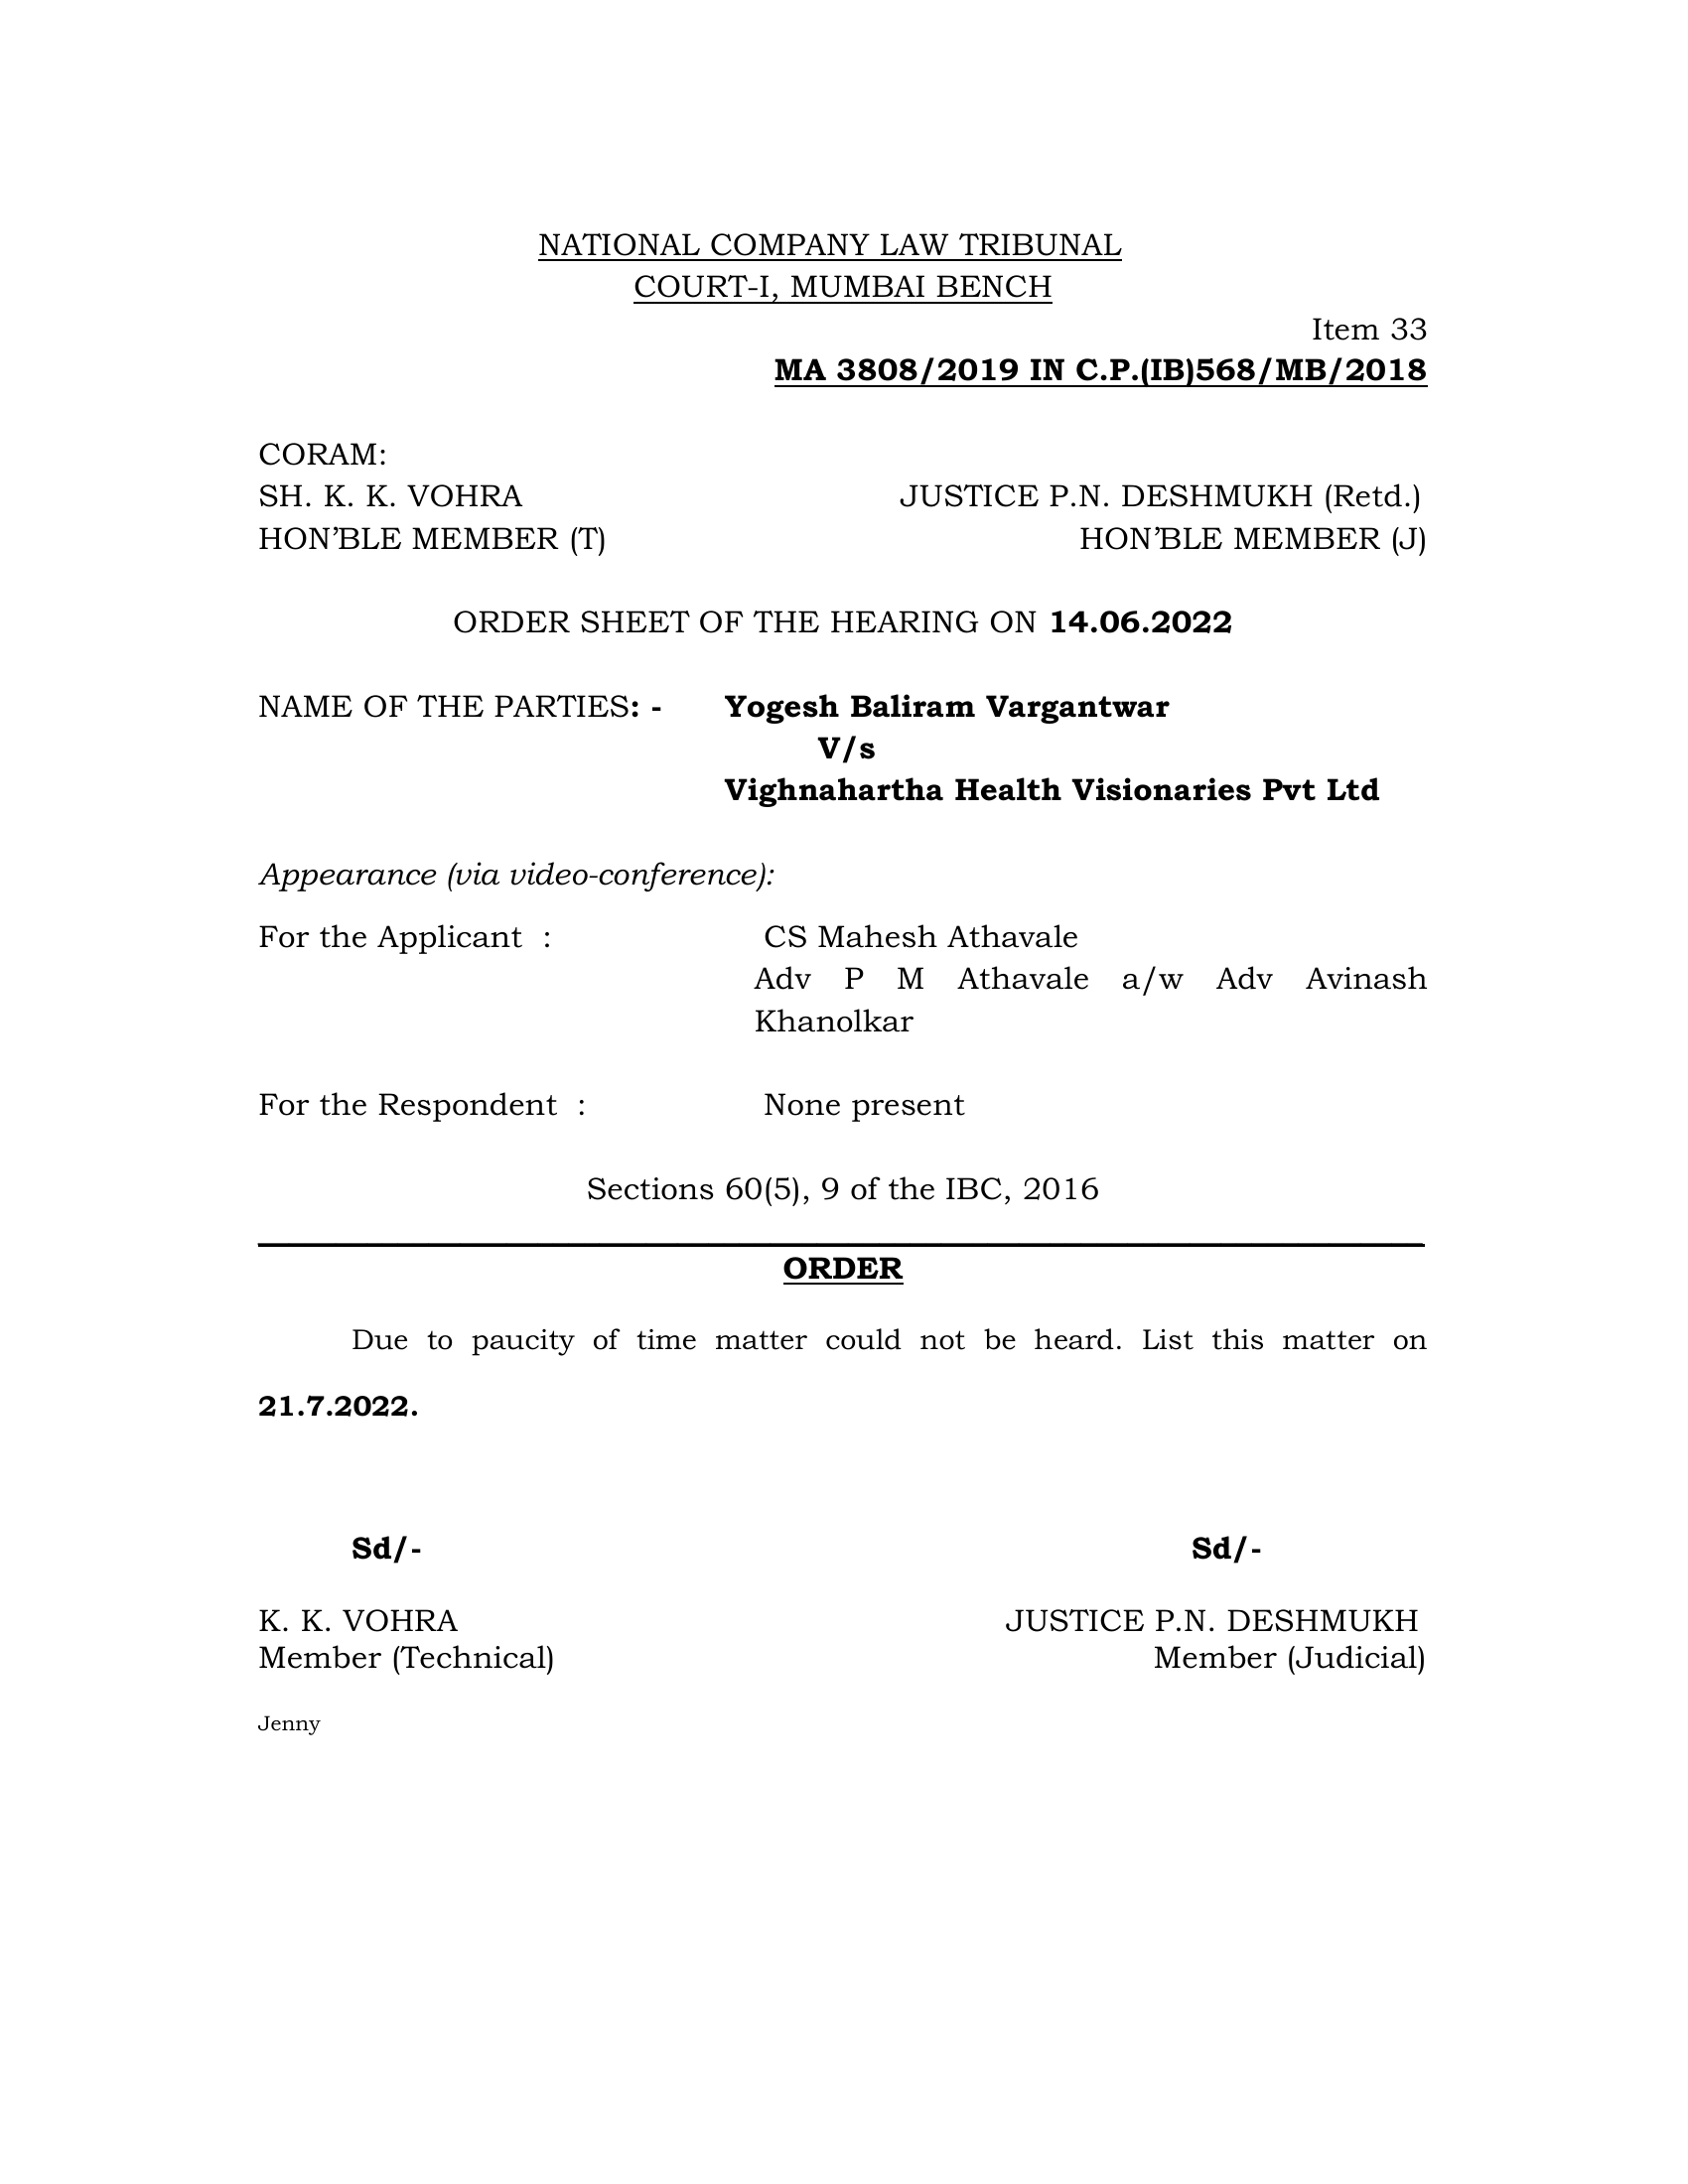

In [ ]:
pdf_blob = NCLT_orders["pdf_blob"][0] # The blob of the first order

convert_from_bytes(pdf_blob)[0] # Displaying the first page of the order

## 4.8 Extract text from PDFs

To apply NLP techniques, the text must first be extracted from the PDFs.

In most cases, the text is embedded in the PDF, which means it can be easily extracted. In other cases, optical character recognition (OCR) is used to extract the text, which means converting images of text into editable and searchable formats.

The `read_pdf_text_from_blob` function reads text from byte data. When text is embedded in the PDF, `pdfplumber` extracts it directly. If this extraction fails, `tesseract` applies OCR to retrieve the text.

While the extraction may not be flawless, it is generally adequate for NLP tasks. Instances where watermarks or handheld scanning hinder extraction exit, but they rare.

As an example, we extract the text of the first PDF file in the database, which is shown section 4.7.

In [ ]:
read_pdf_text_from_blob(NCLT_orders["pdf_blob"][0])

'NATIONAL COMPANY LAW TRIBUNAL\nCOURT-I, MUMBAI BENCH\nItem 33\nMA 3808/2019 IN C.P.(IB)568/MB/2018\nCORAM:\nSH. K. K. VOHRA JUSTICE P.N. DESHMUKH (Retd.)\nHON’BLE MEMBER (T) HON’BLE MEMBER (J)\nORDER SHEET OF THE HEARING ON 14.06.2022\nNAME OF THE PARTIES: - Yogesh Baliram Vargantwar\nV/s\nVighnahartha Health Visionaries Pvt Ltd\nAppearance (via video-conference):\nFor the Applicant : CS Mahesh Athavale\nAdv P M Athavale a/w Adv Avinash\nKhanolkar\nFor the Respondent : None present\nSections 60(5), 9 of the IBC, 2016\n___________________________________________________________________________\nORDER\nDue to paucity of time matter could not be heard. List this matter on\n21.7.2022.\nSd/- Sd/-\nK. K. VOHRA JUSTICE P.N. DESHMUKH\nMember (Technical) Member (Judicial)\nJenny\n'

We use the `apply` method from `pandas` to extract the text of all the files. We store in new column called `pdf_text`.

In [ ]:
NCLT_orders["pdf_text"] = NCLT_orders["pdf_blob"].apply(read_pdf_text_from_blob) # This will take some time to execute

# 6 Unsupervised classifcation through Large Language Models

A major advantage of using large language models (LLMs) for this task is that they eliminate the need for labeled training data, which is often expensive and time-consuming to produce. Instead of relying on manually annotated datasets, the model leverages its pre-trained knowledge to analyze the text of court orders directly. It classifies orders by recognizing patterns and structures learned from extensive training on large text corpora.

In this unsupervised approach, the LLM identifies relevant features and characteristics of the text without predefined labels. We provide the LLM with instructions similar to the guidelines given to a law intern for making the classification. The model uses its contextual understanding and semantic insights to determine whether a court order is substantive or non-substantive, enabling effective classification without manual labeling.

We install and use Ollama, an open-source tool that facilitates working with LLMs locally. Ollama offers an easy-to-use interface for managing models, enabling deployment on local machines without requiring cloud-based solutions. Running LLMs locally, like the 27-billion-parameter Gemma 2 model by Google, provides flexibility and control. Other similar models can also be used in this setup.

Language model APIs by [OpenAI](https://platform.openai.com/), [Groq](https://groq.com/), can also be used instead of an LLM running locally.  

## 6.1 Setting up

In this cell, we download and install Ollama by executing a script from the Ollama website using a shell command. After installation, the Ollama server is started, and the specified model (`gemma2:27b`) is downloaded from the Ollama library.

The form input allows you to change the model, with a full list of available models found on their [website](https://ollama.com/library/).

The model runs in the background, enabling it to be used for processing tasks locally, without relying on cloud-based services.

**Note:** Commands starting with `!` are bash commands executed directly in the shell.

In [ ]:
# Find Ollama models: https://ollama.com/library/

MODEL_NAME = "llama3.2-vision" # @param {"type":"string","placeholder":"Model Name"}
!curl -fsSL https://ollama.com/install.sh | sh # Download and install Ollama
!nohup ollama serve & # Start Ollama server
!ollama pull {MODEL_NAME} # Download model
!nohup ollama run {MODEL_NAME} & # Run the model in the background

>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
############################################################################################# 100.0%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> NVIDIA GPU installed.
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.
nohup: appending output to 'nohup.out'
pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠼ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠧ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠙ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠼ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest 
pulling 11f274007f09...   0% ▕▏    0 B/6.0 GB                  pulling manifest 
pulling 11f274007f09...   0% ▕▏    0 B

In [ ]:
llm = Ollama(model="llama3.2-vision", temperature=0)

We initiate the model using Langchain's Ollama constructor.

In [ ]:
llm.invoke("h1")

'It looks like you just typed "h1". Is there something specific you\'d like to talk about or ask? I\'m here to help!'

In [ ]:
import base64
from io import BytesIO

from IPython.display import HTML, display
from PIL import Image

def convert_to_base64(pil_image):
    """
    Convert PIL image to base64 with basic optimization that Ollama can handle reliably
    """
    # Convert to grayscale (more reliable than binary)
    gray_image = pil_image.convert('L')

    # Moderate size reduction
    max_dimension = 1000
    ratio = min(max_dimension / float(gray_image.size[0]),
               max_dimension / float(gray_image.size[1]))
    new_size = tuple([int(dim * ratio) for dim in gray_image.size])

    # Basic resize
    resized_image = gray_image.resize(new_size, Image.LANCZOS)

    # Save as JPEG with moderate compression
    buffered = BytesIO()
    resized_image.save(buffered,
                      format="JPEG",
                      quality=50,
                      optimize=True)

    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return img_str

In [ ]:

# Function to extract metadata from court orders
def extract_metadata(images):
    llm_with_image_context= llm.bind(images=images)

    response =  llm_with_image_context.invoke("""

        Extract the names of the judges from the court order based on the following categories:
        1. **Technical Member**
        2. **Judicial Member**

        #### **Output Format**
        Return the metadata strictly in the following JSON format. Don't mention any steps or explanation.
        {Coram Technical Member: [name], Coram Judicial Member: [name]}

        #### **Additional information**
        * Exclude titles like "HON'BLE MEMBER (T)" and "HON'BLE MEMBER (J)" from the names. These denote Technical and Judicial members but are not part of the names themselves.
        * The Coram Judicial Member is often referred to as **JUSTICE** or may have prefixes like "Hon'ble Mr./Ms." followed by their name.
        * The Coram Technical Member will not have "JUSTICE" as a prefix.
        * The Technical and Judicial Members may appear in any order within the text.
        * Technical member can be written in many ways, including Member (T), Member (Technical), etc
        * Judicial member can be written in many ways, including Member (J), Member (Judicial), etc
        * JUST GIVE THE JSON. NO EXPLANATION.
                """)
    print(response)
    return response


metadata_df = pd.DataFrame(columns=[
    'order_text', 'coram_technical_member', 'coram_judicial_member',
])
# Define a function to extract metadata from the string format
def parse_metadata(metadata_string):
    # Regular expression to capture the members' names
    technical_member = re.search(r"Coram Technical Member: (.*?)(?=,|$)", metadata_string)
    judicial_member = re.search(r"Coram Judicial Member: (.*?)(?=}|$)", metadata_string)

    # Extract names, or set to empty string if not found
    technical_name = technical_member.group(1).strip() if technical_member else ''
    judicial_name = judicial_member.group(1).strip() if judicial_member else ''

    return {
        'coram_technical_member': technical_name,
        'coram_judicial_member': judicial_name
    }

# Process the orders
for index, row in tqdm(NCLT_orders.head(100).iterrows(), total=100):
    # Read and clean the order text
    order_text = row['pdf_text']
    # Convert PDF to a list of PIL images (one image per PDF page)
    images = convert_from_bytes(row['pdf_blob'])

    parsed_metadata =  parse_metadata(extract_metadata([convert_to_base64(images[-1])]))

    # Create a DataFrame row for the current order
    new_row = pd.DataFrame({
        'order_text': [order_text],
        'coram_technical_member': [parsed_metadata['coram_technical_member']],
        'coram_judicial_member': [parsed_metadata['coram_judicial_member']],
    })

    # Append the new row to the main DataFrame
    metadata_df = pd.concat([metadata_df, new_row], ignore_index=True)

  1%|          | 1/100 [00:44<1:12:48, 44.13s/it]

{Coram Technical Member: K.K.Vohra, Coram Judicial Member: P.N.Deshmukh}


  2%|▏         | 2/100 [00:52<37:50, 23.16s/it]  

{Coram Technical Member: Kapal Kumar Vohra, Coram Judicial Member: Pradeep Narhari Deshmukh}


  3%|▎         | 3/100 [01:01<26:50, 16.61s/it]

{Coram Technical Member: Kapal Kumar Vohra, Coram Judicial Member: Pradeep Narhari Deshmukh}


  4%|▍         | 4/100 [01:09<21:24, 13.38s/it]

{Coram Technical Member: Shyam Babu Gautam, Coram Judicial Member: P.N. Deshmukh}


  5%|▌         | 5/100 [01:18<18:29, 11.68s/it]

{Coram Technical Member: SHYAM BABU GAUTAM, Coram Judicial Member: SUCHITRA KANUPARTHI}


  6%|▌         | 6/100 [01:27<16:53, 10.78s/it]

{Coram Technical Member: PRABHAT KUMAR, Coram Judicial Member: KISHORE VEMULAPALLI}


  7%|▋         | 7/100 [01:36<15:42, 10.13s/it]

{Coram Technical Member: SHYAM BABU GAUTAM, Coram Judicial Member: JUSTICE P.N. DESHMUKH}


  8%|▊         | 8/100 [01:45<14:55,  9.73s/it]

{Coram Technical Member: SHYAM BABU GAUTAM, Coram Judicial Member: JUSTICE P.N. DESHMUKH}


  9%|▉         | 9/100 [01:54<14:20,  9.46s/it]

{Coram Technical Member: MANOJ KUMAR DUBEY, Coram Judicial Member: KISHORE VEMULAPALLI}


 10%|█         | 10/100 [02:02<13:54,  9.28s/it]

{Coram Technical Member: SHRI K.K. SINGH, Coram Judicial Member: SHRI H.V. SUBBA RAO}


 11%|█         | 11/100 [02:12<13:42,  9.24s/it]

{Coram Technical Member: Manoj Kumar Dubey, Coram Judicial Member: Kishore Vemulapalli}


 12%|█▏        | 12/100 [02:20<13:21,  9.11s/it]

{Coram Technical Member: CHANDRA BHAN SINGH, Coram Judicial Member: SUBBA RAO}


 13%|█▎        | 13/100 [02:30<13:18,  9.18s/it]

{Coram Technical Member: K.K. Vohra, Coram Judicial Member: P.N. Deshmukh}


 14%|█▍        | 14/100 [02:39<13:12,  9.22s/it]

{Coram Technical Member: SHRI RAJESH SHARMA, Coram Judicial Member: SHRI KISHORE VEMULAPALLI}


 15%|█▌        | 15/100 [02:48<13:02,  9.20s/it]

{Coram Technical Member: SHRI RAJESH SHARMA, Coram Judicial Member: SMT. SUCHITRA KANUPARTHI}


 16%|█▌        | 16/100 [02:57<12:51,  9.19s/it]

{Coram Technical Member: SHRI RAJESH SHARMA, Coram Judicial Member: SMT. SUCHITRA KANUPARTHI}


 17%|█▋        | 17/100 [03:07<12:44,  9.21s/it]

{Coram Technical Member: SMT. ANURADHA SANJAY BHATIA, Coram Judicial Member: SMT. SUCHITRA KANUPARTHI}


 18%|█▊        | 18/100 [03:16<12:25,  9.10s/it]

{Coram Technical Member: SHYAM BABU GAUTAM, Coram Judicial Member: P.N. DESHMUKH}


 19%|█▉        | 19/100 [03:25<12:22,  9.16s/it]

{Coram Technical Member: RAJESH SHARMA, Coram Judicial Member: H.V. SUBBA RAO}


 20%|██        | 20/100 [03:34<12:23,  9.30s/it]

{Coram Technical Member: SHYAM BABU GAUTAM, Coram Judicial Member: JUSTICE P.N. DESHMUKH}


 21%|██        | 21/100 [03:43<12:07,  9.21s/it]

{Coram Technical Member: SHYAM BABU GAUTAM, Coram Judicial Member: P.N. DESHMUKH}


 22%|██▏       | 22/100 [03:52<11:52,  9.13s/it]

{Coram Technical Member: SHYAM BABU GAUTAM, Coram Judicial Member: P.N. DESHMUKH}


 23%|██▎       | 23/100 [04:01<11:39,  9.08s/it]

{Coram Technical Member: SHYAM BABU GAUTAM, Coram Judicial Member: P.N. DESHMUKH}


 24%|██▍       | 24/100 [04:11<11:36,  9.16s/it]

{Coram Technical Member: SMT. ANURADHA SANJAY BHATIA, Coram Judicial Member: SMT. SUCHITRA KANUPARTHI}


 25%|██▌       | 25/100 [04:20<11:22,  9.09s/it]

{Coram Technical Member: SHYAM BABU GAUTAM, Coram Judicial Member: P.N. DESHMUKH}


 26%|██▌       | 26/100 [04:29<11:13,  9.10s/it]

{Coram Technical Member: SHRI RAJESH SHARMA, Coram Judicial Member: SHRI KISHORE VEMULAPALLI}


 27%|██▋       | 27/100 [04:38<11:04,  9.10s/it]

{Coram Technical Member: CHANDRA BHAN SINGH, Coram Judicial Member: SUBBA RAO}


 28%|██▊       | 28/100 [04:47<10:50,  9.03s/it]

{Coram Technical Member: SHYAM BABU GAUTAM, Coram Judicial Member: P.N. DESHMUKH}


 29%|██▉       | 29/100 [04:56<10:38,  9.00s/it]

{Coram Technical Member: CHANDRA BHAN SINGH, Coram Judicial Member: H.V. SUBBA RAO}


 30%|███       | 30/100 [05:05<10:38,  9.12s/it]

{Coram Technical Member: SHRI RAJESH SHARMA, Coram Judicial Member: SHRI KISHORE VEMULAPALLI}


 31%|███       | 31/100 [05:14<10:21,  9.01s/it]

{Coram Technical Member: CHANDRA BHAN SINGH, Coram Judicial Member: SUBBA RAO}


 32%|███▏      | 32/100 [05:23<10:10,  8.98s/it]

{Coram Technical Member: RAJESH SHARMA, Coram Judicial Member: SUCHITRA KANUPARTHI}


 33%|███▎      | 33/100 [05:32<10:04,  9.02s/it]

{Coram Technical Member: SHYAM BABU GAUTAM, Coram Judicial Member: JUSTICE P.N. DESHMUKH}


 34%|███▍      | 34/100 [05:41<10:00,  9.10s/it]

{Coram Technical Member: SHRI RAJESH SHARMA, Coram Judicial Member: SMT. SUCHITRA KANUPARTHI}


 35%|███▌      | 35/100 [05:50<09:56,  9.18s/it]

{Coram Technical Member: SMT. ANURADHA SANJAY BHATIA, Coram Judicial Member: SMT. SUCHITRA KANUPARTHI}


 36%|███▌      | 36/100 [05:59<09:43,  9.11s/it]

{Coram Technical Member: SHYAM BABU GAUTAM, Coram Judicial Member: P.N. DESHMUKH}


 37%|███▋      | 37/100 [06:09<09:36,  9.15s/it]

{Coram Technical Member: SHYAM BABU GAUTAM, Coram Judicial Member: H.V.SUBBA RAO}


 38%|███▊      | 38/100 [06:18<09:22,  9.08s/it]

{Coram Technical Member: SHYAM BABU GAUTAM, Coram Judicial Member: P.N. DESHMUKH}


 39%|███▉      | 39/100 [06:26<09:08,  8.99s/it]

{Coram Technical Member: CHANDRA BHAN SINGH, Coram Judicial Member: SUBBA RAO}


 40%|████      | 40/100 [06:36<09:03,  9.06s/it]

{Coram Technical Member: SHRI SHYAM BABU GAUTAM, Coram Judicial Member: SHRI KISHORE VEMULAPALLI}


 41%|████      | 41/100 [06:45<08:58,  9.13s/it]

{Coram Technical Member: NARENDER KUMAR BHOLA, Coram Judicial Member: BHASKARA PANTULA MOHAN}


 42%|████▏     | 42/100 [06:55<09:13,  9.53s/it]

{Coram Technical Member: Anuradha Sanjay Bhatia, Coram Judicial Member: Suchitra Kanuparthi}


 43%|████▎     | 43/100 [07:04<08:54,  9.38s/it]

{Coram Technical Member: SHYAM BABU GAUTAM, Coram Judicial Member: TELAPROLU RAJANI}


 44%|████▍     | 44/100 [07:13<08:40,  9.29s/it]

{Coram Technical Member: SHYAM BABU GAUTAM, Coram Judicial Member: P.N. DESHMUKH}


 45%|████▌     | 45/100 [07:22<08:23,  9.15s/it]

{Coram Technical Member: K.K.Vohra, Coram Judicial Member: Justice P.N.Deshmukh}


 46%|████▌     | 46/100 [07:31<08:11,  9.11s/it]

{Coram Technical Member: ANURADHA SANJAY BHATIA, Coram Judicial Member: H.V.SUBBA RAO}


 47%|████▋     | 47/100 [07:40<07:59,  9.04s/it]

{Coram Technical Member: Shyam Babu Gautam, Coram Judicial Member: P.N. Deshmukh}


 48%|████▊     | 48/100 [07:49<07:51,  9.06s/it]

{Coram Technical Member: SHYAM BABU GAUTAM, Coram Judicial Member: P.N. DESHMUKH}


 49%|████▉     | 49/100 [07:58<07:41,  9.04s/it]

{Coram Technical Member: SHYAM BABU GAUTAM, Coram Judicial Member: JUSTICE P.N. DESHMUKH}


 50%|█████     | 50/100 [08:08<07:37,  9.15s/it]

{Coram Technical Member: SMT. ANURADHA SANJAY BHATIA, Coram Judicial Member: SMT. SUCHITRA KANUPARTHI}


 51%|█████     | 51/100 [08:17<07:31,  9.21s/it]

{Coram Technical Member: MANOJ KUMAR DUBEY, Coram Judicial Member: KISHORE VEMULAPALLI}


 52%|█████▏    | 52/100 [08:26<07:20,  9.17s/it]

{Coram Technical Member: SHRI RAJESH SHARMA, Coram Judicial Member: SHRI KISHORE VEMULAPALLI}


 53%|█████▎    | 53/100 [08:35<07:08,  9.12s/it]

{Coram Technical Member: SHYAM BABU GAUTAM, Coram Judicial Member: ASHOK KUMAR BORAH}


 54%|█████▍    | 54/100 [08:44<06:55,  9.04s/it]

{Coram Technical Member: RAJESH SHARMA, Coram Judicial Member: SUCHITRA KANUPARTHI}


 55%|█████▌    | 55/100 [08:53<06:45,  9.02s/it]

{Coram Technical Member: SHYAM BABU GAUTAM, Coram Judicial Member: SUCHITRA KANUPARTHI}


 56%|█████▌    | 56/100 [09:02<06:33,  8.95s/it]

{Coram Technical Member: K.K.Vohra, Coram Judicial Member: P.N.Deshmukh}


 57%|█████▋    | 57/100 [09:11<06:26,  8.99s/it]

{Coram Technical Member: SHRI RAJESH SHARMA, Coram Judicial Member: SHRI KISHORE VEMULAPALLI}


 58%|█████▊    | 58/100 [09:20<06:23,  9.12s/it]

{Coram Technical Member: SHYAM BABU GAUTAM, Coram Judicial Member: JUSTICE P.N. DESHMUKH}


 59%|█████▉    | 59/100 [09:29<06:13,  9.12s/it]

{Coram Technical Member: MANOJ KUMAR DUBEY, Coram Judicial Member: KISHORE VEMULAPALLI}


 60%|██████    | 60/100 [09:38<06:02,  9.07s/it]

{Coram Technical Member: SHYAM BABU GAUTAM, Coram Judicial Member: P.N. DESHMUKH}


 61%|██████    | 61/100 [09:47<05:53,  9.06s/it]

{Coram Technical Member: Kapal Kumar Vohra, Coram Judicial Member: Pradeep Narhari Deshmukh}


 62%|██████▏   | 62/100 [09:56<05:44,  9.08s/it]

{Coram Technical Member: MANOJ KUMAR DUBEY, Coram Judicial Member: KISHORE VEMULAPALLI}


 63%|██████▎   | 63/100 [10:05<05:34,  9.04s/it]

{Coram Technical Member: SHYAM BABU GAUTAM, Coram Judicial Member: P.N. DESHMUKH}


 64%|██████▍   | 64/100 [10:14<05:23,  9.00s/it]

{Coram Technical Member: Shyam Babu Gautam, Coram Judicial Member: P.N. Deshmukh}


 65%|██████▌   | 65/100 [10:24<05:20,  9.17s/it]

{Coram Technical Member: NARENDER KUMAR BHOLA, Coram Judicial Member: BHASKARA PANTULA MOHAN}


 66%|██████▌   | 66/100 [10:33<05:10,  9.14s/it]

{Coram Technical Member: SHRI RAJESH SHARMA, Coram Judicial Member: SMT. SUCHITRA KANUPARTHI}


 67%|██████▋   | 67/100 [10:42<05:00,  9.10s/it]

{Coram Technical Member: ANURADHA SANJAY BHATIA, Coram Judicial Member: SUCHITRA KANUPARTHI}


 68%|██████▊   | 68/100 [10:51<04:52,  9.13s/it]

{Coram Technical Member: SHYAM BABU GAUTAM, Coram Judicial Member: P.N. DESHMUKH}


 69%|██████▉   | 69/100 [11:00<04:43,  9.13s/it]

{Coram Technical Member: SHRI RAJESH SHARMA, Coram Judicial Member: SMT. SUCHITRA KANUPARTHI}


 70%|███████   | 70/100 [11:09<04:32,  9.09s/it]

{Coram Technical Member: SHYAM BABU GAUTAM, Coram Judicial Member: ASHOK KUMAR BORAH}


 71%|███████   | 71/100 [11:18<04:23,  9.10s/it]

{Coram Technical Member: SHRI RAJESH SHARMA, Coram Judicial Member: SHRI KISHORE VEMULAPALLI}


 72%|███████▏  | 72/100 [11:28<04:21,  9.33s/it]

{Coram Technical Member: Anuradha Sanjay Bhatia, Coram Judicial Member: Justice Ramalingam Sudhakar}


 73%|███████▎  | 73/100 [11:37<04:08,  9.20s/it]

{Coram Technical Member: SHYAM BABU GAUTAM, Coram Judicial Member: P.N. DESHMUKH}


 74%|███████▍  | 74/100 [11:46<03:57,  9.13s/it]

{Coram Technical Member: SHYAM BABU GAUTAM, Coram Judicial Member: P.N. DESHMUKH}


 75%|███████▌  | 75/100 [11:56<03:50,  9.22s/it]

{Coram Technical Member: SHRI RAJESH SHARMA, Coram Judicial Member: SMT. SUCHITRA KANUPARTHI}


 76%|███████▌  | 76/100 [12:05<03:40,  9.17s/it]

{Coram Technical Member: SHYAM BABU GAUTAM, Coram Judicial Member: ASHOK KUMAR BORAH}


 77%|███████▋  | 77/100 [12:14<03:29,  9.10s/it]

{Coram Technical Member: SHYAM BABU GAUTAM, Coram Judicial Member: P.N. DESHMUKH}


 78%|███████▊  | 78/100 [12:23<03:20,  9.13s/it]

{Coram Technical Member: SHRI CHANDRA BHAN SINGH, Coram Judicial Member: SHRI KISHORE VEMULAPALLI}


 79%|███████▉  | 79/100 [12:32<03:12,  9.18s/it]

{Coram Technical Member: CHANDRA BHAN SINGH, Coram Judicial Member: H.V. SUBBA RAO}


 80%|████████  | 80/100 [12:41<03:02,  9.12s/it]

{Coram Technical Member: SHYAM BABU GAUTAM, Coram Judicial Member: H.V. SUBBA RAO}


 81%|████████  | 81/100 [12:50<02:53,  9.11s/it]

{Coram Technical Member: SHRI RAJESH SHARMA, Coram Judicial Member: SHRI KISHORE VEMULAPALLI}


 82%|████████▏ | 82/100 [12:59<02:45,  9.17s/it]

{Coram Technical Member: Shri Shyam Babu Gautam, Coram Judicial Member: Justice P.N. Deshmukh}


 83%|████████▎ | 83/100 [13:08<02:34,  9.11s/it]

{Coram Technical Member: Kapal Kumar Vohra, Coram Judicial Member: Justice Pradeep Narhari Deshmukh}


 84%|████████▍ | 84/100 [13:17<02:24,  9.02s/it]

{Coram Technical Member: Kapal Kumar Vohra, Coram Judicial Member: P.N. Deshmukh}


 85%|████████▌ | 85/100 [13:26<02:14,  8.98s/it]

{Coram Technical Member: SHYAM BABU GAUTAM, Coram Judicial Member: P.N. DESHMUKH}


 86%|████████▌ | 86/100 [13:35<02:05,  9.00s/it]

{Coram Technical Member: SHYAM BABU GAUTAM, Coram Judicial Member: P.N. DESHMUKH}


 87%|████████▋ | 87/100 [13:44<01:57,  9.03s/it]

{Coram Technical Member: SHRI RAJESH SHARMA, Coram Judicial Member: SHRI KISHORE VEMULAPALLI}


 88%|████████▊ | 88/100 [13:53<01:48,  9.05s/it]

{Coram Technical Member: ANURADHA SANJAY BHATIA, Coram Judicial Member: SUCHITRA KANUPARTHI}


 89%|████████▉ | 89/100 [14:02<01:39,  9.07s/it]

{Coram Technical Member: CHANDRA BHAN SINGH, Coram Judicial Member: SUBBA RAO}


 90%|█████████ | 90/100 [14:11<01:30,  9.02s/it]

{Coram Technical Member: SHYAM BABU GAUTAM, Coram Judicial Member: P.N. DESHMUKH}


 91%|█████████ | 91/100 [14:20<01:21,  9.01s/it]

{Coram Technical Member: CHANDRA BHAN SINGH, Coram Judicial Member: SUCHITRA KANUPARTHI}


 92%|█████████▏| 92/100 [14:30<01:12,  9.05s/it]

{Coram Technical Member: SHRI RAJESH SHARMA, Coram Judicial Member: SHRI KISHORE VEMULAPALLI}


 93%|█████████▎| 93/100 [14:38<01:03,  9.01s/it]

{Coram Technical Member: SHYAM BABU GAUTAM, Coram Judicial Member: P.N. DESHMUKH}


 94%|█████████▍| 94/100 [14:47<00:54,  9.01s/it]

{Coram Technical Member: KAPAL KUMAR VOHRA, Coram Judicial Member: SUCHITRA KANUPARTHI}


 95%|█████████▌| 95/100 [14:56<00:45,  9.02s/it]

{Coram Technical Member: SHYAM BABU GAUTAM, Coram Judicial Member: JUSTICE P.N. DESHMUKH}


 96%|█████████▌| 96/100 [15:06<00:36,  9.08s/it]

{Coram Technical Member: SHYAM BABU GAUTAM, Coram Judicial Member: P.N. DESHMUKH}


 97%|█████████▋| 97/100 [15:15<00:27,  9.04s/it]

{Coram Technical Member: Kapal Kumar Vohra, Coram Judicial Member: Pradeep Narhari Deshmukh}


 98%|█████████▊| 98/100 [15:24<00:18,  9.04s/it]

{Coram Technical Member: ANURADHA SANJAY BHATIA, Coram Judicial Member: H.V. SUBBA RAO}


 99%|█████████▉| 99/100 [15:33<00:09,  9.12s/it]

{Coram Technical Member: SHYAM BABU GAUTAM, Coram Judicial Member: JUSTICE P.N. DESHMUKH}


100%|██████████| 100/100 [15:42<00:00,  9.42s/it]

{Coram Technical Member: CHANDRA BHAN SINGH, Coram Judicial Member: SUCHITRA KANUPARTHI}


In [ ]:
metadata_df.to_excel("judges_vision_last_page.xlsx", engine='openpyxl', index=False)